**Table of contents**<a id='toc0_'></a>    
- [Interconnect Churn](#toc1_)    
  - [Purpose](#toc1_1_)    
  - [Feature Engineering](#toc1_2_)    
  - [Clustering](#toc1_3_)    
  - [Modeling](#toc1_4_)    
  - [Final Work Plan](#toc1_5_)    
  - [Feature Engineering](#toc1_6_)    
  - [EDA](#toc1_7_)    
  - [Preprocessing](#toc1_8_)    
- [upsampling](#toc2_)    
- [Results of the upsampling,](#toc3_)    
- [upsampled value counts](#toc4_)    
- [scaling numeric columns](#toc5_)    
    - [K Means Clustering](#toc5_1_1_)    
  - [Modeling](#toc5_2_)    
    - [Classifier Pipeline](#toc5_2_1_)    
      - [ADA Pipeline Feature Importance](#toc5_2_1_1_)    
      - [XGBoost Pipeline Feature Importance](#toc5_2_1_2_)    
      - [LGBM Pipeline Feature Importance](#toc5_2_1_3_)    
      - [Gradient Boost Pipeline Feature Importance](#toc5_2_1_4_)    
      - [CatBoost Pipeline Feature Importance](#toc5_2_1_5_)    
    - [Comparing Models](#toc5_2_2_)    
  - [Final Model](#toc5_3_)    
    - [Final Model Evaluation Metric](#toc5_3_1_)    
    - [Final Model Feature Importances](#toc5_3_2_)    
  - [Overall Conclusions](#toc5_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Interconnect Churn](#toc0_)

## <a id='toc1_1_'></a>[Purpose](#toc0_)

The telecom operator Interconnect would like to forecast churn of their clients. To ensure loyalty, those who are predicted to leave will be offered promotional codes and special plans. 

In [1]:
# !pip install ydata_profiling  

In [2]:
# import libraries
import pandas as pd  
import numpy as np  
import plotly_express as px  
import seaborn as sns
from ydata_profiling.profile_report import ProfileReport
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, train_test_split
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from catboost import CatBoostClassifier, Pool, cv 
from xgboost import XGBClassifier
import lightgbm as lgb
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [3]:
# load data
contract = pd.read_csv('datasets/contract.csv', parse_dates=[1, 2])
internet = pd.read_csv('datasets/internet.csv')
personal = pd.read_csv('datasets/personal.csv')
phone = pd.read_csv('datasets/phone.csv')

In [4]:
# EDA profile reports
con_prof = ProfileReport(contract, title= 'Contract Profile')
int_prof = ProfileReport(internet, title= 'Internet Profile')
per_prof = ProfileReport(personal, title= 'Personal Profile')
pho_prof = ProfileReport(phone, title= 'Contract Profile')

In [5]:
# contract profile report
con_prof

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

The contract dataset contains a few features, and the target variable in the form of end date. If the customer has churned, there will be an end date, otherwise the customer is still with the company. Therefore, we can see class imbalance, which will need to be rectified to improve the score of the model. The column names will need to be changed to lowercase, and underscores will be added to separate words. Customer Id is a common column among all the datasets, therefore we will use that to combine them. Customer id contains 7043 values, and all are unique. Of note, begin date has moderate correlation with type. This dataset does not contain missing values, ut has categorical columns that may need encoding. 

In [6]:
# internet profile report
int_prof

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

The internet dataset contains a customer id column with a few other categorical features. The dataset contains 5517 observations with no missing values. This profile report also shows us the distributions of the different features. Most of the features have two distinct values, the absence or presence of a service. 

In [7]:
# personal profile report
per_prof

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

EDA shows us that gender among the personal dataset is even. A vast majority of customers are not senior citizens, and the distribution of having a partner is fairly even. A majority of customers have dependents. The dataset is free of missing values. 

In [8]:
# phone profile report
pho_prof

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

This dataset has one column that has a yes or no value for multiple lines, paired with customer id. The multiple lines feature is fairly balanced with no values missing. 

## <a id='toc1_2_'></a>[Feature Engineering](#toc0_)

The different datasets will be combined into one full dataset by joining on the column id. The dates column will be parsed to create new features. Furthermore, the end date column will be label encoded. 

## <a id='toc1_3_'></a>[Clustering](#toc0_)

Analysis will be done to se if the the full dataset contains clusters of customers.

## <a id='toc1_4_'></a>[Modeling](#toc0_)

Some boosting models work with categorical features natively, but we may have to label encode those features. We will also need to scale the data, and balance the classes for churn by upsampling. We will then test across a couple of models, and optimize the AUCROC score. Finally, we will see if a voting classifier improves the AUCROC further. 

## <a id='toc1_5_'></a>[Final Work Plan](#toc0_)

1. Read data
2. Combine data
3. Feature engineering/ change column names and types
4. EDA
5. KNN clustering
6. Preprocessing, upscaling, standard scaling
7. Modeling with boost methods and cross validation
8. Hyperparameter tuning
9. Feature importance
10. Visualizing modeling results 
11. Voting Classifier 
12. Visualize final model, feature importance
13. Conclude

## <a id='toc1_6_'></a>[Feature Engineering](#toc0_)

In [9]:
# contract columns
contract.columns

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges'],
      dtype='object')

In [10]:
# change column names
contract.columns = ['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing', 'payment_method', 'monthly_charges', 'total_charges']
internet.columns = [ 'customer_id', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']
personal.columns = ['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents']
phone.columns = ['customer_id', 'multiple_lines']

In [11]:
# new contract columns
contract.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')

In [12]:
# new internet columns
internet.columns

Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')

In [13]:
# new personal columns
personal.columns

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')

In [14]:
# new phone columns
phone.columns

Index(['customer_id', 'multiple_lines'], dtype='object')

In [15]:
# first merge
df2 = contract.merge(internet, how='left')

In [16]:
# results of first merge 
df2.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges',
       'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')

In [17]:
# second merge
df3 = df2.merge(personal, how='left')

In [18]:
# second merge results
df3.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges',
       'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'gender', 'senior_citizen', 'partner', 'dependents'],
      dtype='object')

In [19]:
# final merge
df = df3.merge(phone, how='left')

In [20]:
# final dataset columns
df.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges',
       'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'gender', 'senior_citizen', 'partner', 'dependents', 'multiple_lines'],
      dtype='object')

In [21]:
# info on the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   object        
 8   internet_service   5517 non-null   object        
 9   online_security    5517 non-null   object        
 10  online_backup      5517 non-null   object        
 11  device_protection  5517 non-null   object        
 12  tech_support       5517 non-null   object        
 13  streaming_tv       5517 non-null   object        
 14  streamin

In [22]:
# look at df
df.head()

customer_id begin_date             end_date            type  \
0  7590-VHVEG 2020-01-01                   No  Month-to-month   
1  5575-GNVDE 2017-04-01                   No        One year   
2  3668-QPYBK 2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW 2016-05-01                   No        One year   
4  9237-HQITU 2019-09-01  2019-11-01 00:00:00  Month-to-month   

  paperless_billing             payment_method  monthly_charges total_charges  \
0               Yes           Electronic check            29.85         29.85   
1                No               Mailed check            56.95        1889.5   
2               Yes               Mailed check            53.85        108.15   
3                No  Bank transfer (automatic)            42.30       1840.75   
4               Yes           Electronic check            70.70        151.65   

  internet_service online_security online_backup device_protection  \
0              DSL              No           Yes                No   
1              DSL             Yes            No               Yes   
2              DSL             Yes           Yes                No   
3              DSL             Yes            No               Yes   
4      Fiber optic              No            No                No   

  tech_support streaming_tv streaming_movies  gender  senior_citizen partner  \
0           No           No               No  Female               0     Yes   
1           No           No               No    Male               0      No   
2           No           No               No    Male               0      No   
3          Yes           No               No    Male               0      No   
4           No           No               No  Female               0      No   

  dependents multiple_lines  
0         No            NaN  
1         No             No  
2         No             No  
3         No            NaN  
4         No             No

In [23]:
# extracting new features from begin date
df['year'] = df.begin_date.dt.year
df['month'] = df.begin_date.dt.month
df['day'] = df.begin_date.dt.day
df['quarter'] = df.begin_date.dt.quarter

In [24]:
# create churn column
df['churn'] = np.where(df['end_date'] == 'No', 0, 1)

In [25]:
# drop ed_date for churn 
df.drop(columns=['end_date', 'customer_id', 'begin_date'], inplace=True)

In [26]:
# look at the data
df.head()

type paperless_billing             payment_method  \
0  Month-to-month               Yes           Electronic check   
1        One year                No               Mailed check   
2  Month-to-month               Yes               Mailed check   
3        One year                No  Bank transfer (automatic)   
4  Month-to-month               Yes           Electronic check   

   monthly_charges total_charges internet_service online_security  \
0            29.85         29.85              DSL              No   
1            56.95        1889.5              DSL             Yes   
2            53.85        108.15              DSL             Yes   
3            42.30       1840.75              DSL             Yes   
4            70.70        151.65      Fiber optic              No   

  online_backup device_protection tech_support  ...  gender senior_citizen  \
0           Yes                No           No  ...  Female              0   
1            No               Yes           No  ...    Male              0   
2           Yes                No           No  ...    Male              0   
3            No               Yes          Yes  ...    Male              0   
4            No                No           No  ...  Female              0   

  partner  dependents multiple_lines  year month  day  quarter  churn  
0     Yes          No            NaN  2020     1    1        1      0  
1      No          No             No  2017     4    1        2      0  
2      No          No             No  2019    10    1        4      1  
3      No          No            NaN  2016     5    1        2      0  
4      No          No             No  2019     9    1        3      1  

[5 rows x 22 columns]

In [27]:
# check for missing values
df.isna().sum()

type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
gender                  0
senior_citizen          0
partner                 0
dependents              0
multiple_lines        682
year                    0
month                   0
day                     0
quarter                 0
churn                   0
dtype: int64

In [28]:
# fill missing values with No, representing no service
df.fillna('No', inplace=True)

In [29]:
# recheck for missing values
df.isna().sum().sum()

0

In [30]:
# we found empty strings
df.query("total_charges==' '")

type paperless_billing             payment_method  monthly_charges  \
488   Two year               Yes  Bank transfer (automatic)            52.55   
753   Two year                No               Mailed check            20.25   
936   Two year                No               Mailed check            80.85   
1082  Two year                No               Mailed check            25.75   
1340  Two year                No    Credit card (automatic)            56.05   
3331  Two year                No               Mailed check            19.85   
3826  Two year                No               Mailed check            25.35   
4380  Two year                No               Mailed check            20.00   
5218  One year               Yes               Mailed check            19.70   
6670  Two year                No               Mailed check            73.35   
6754  Two year               Yes  Bank transfer (automatic)            61.90   

     total_charges internet_service online_security online_backup  \
488                             DSL             Yes            No   
753                              No              No            No   
936                             DSL             Yes           Yes   
1082                             No              No            No   
1340                            DSL             Yes           Yes   
3331                             No              No            No   
3826                             No              No            No   
4380                             No              No            No   
5218                             No              No            No   
6670                            DSL              No           Yes   
6754                            DSL             Yes           Yes   

     device_protection tech_support  ...  gender senior_citizen partner  \
488                Yes          Yes  ...  Female              0     Yes   
753                 No           No  ...    Male              0      No   
936                Yes           No  ...  Female              0     Yes   
1082                No           No  ...    Male              0     Yes   
1340               Yes          Yes  ...  Female              0     Yes   
3331                No           No  ...    Male              0     Yes   
3826                No           No  ...    Male              0     Yes   
4380                No           No  ...  Female              0     Yes   
5218                No           No  ...    Male              0     Yes   
6670               Yes          Yes  ...  Female              0     Yes   
6754                No          Yes  ...    Male              0      No   

      dependents multiple_lines  year month  day  quarter  churn  
488          Yes             No  2020     2    1        1      0  
753          Yes             No  2020     2    1        1      0  
936          Yes             No  2020     2    1        1      0  
1082         Yes            Yes  2020     2    1        1      0  
1340         Yes             No  2020     2    1        1      0  
3331         Yes             No  2020     2    1        1      0  
3826         Yes            Yes  2020     2    1        1      0  
4380         Yes             No  2020     2    1        1      0  
5218         Yes             No  2020     2    1        1      0  
6670         Yes            Yes  2020     2    1        1      0  
6754         Yes            Yes  2020     2    1        1      0  

[11 rows x 22 columns]

In [31]:
# percentage of missing values
df.query("total_charges==' '")['total_charges'].count()/len(df) * 100

0.1561834445548772

Less than 0.2 % of the data has missing total charges.  

In [32]:
# drop those rows where total charges is an empty string
df = df.drop(df[df['total_charges'] == ' '].index)

Initially, we thought to fill in these missing total charges with zero, but that would mean we made an inference that these customers did not use any services during their contract. We could have tried imputing the values, but since it represents only 0.2% of the data, we will drop it. 

In [33]:
# checking proper implementation
df.query("total_charges==' '")

Empty DataFrame
Columns: [type, paperless_billing, payment_method, monthly_charges, total_charges, internet_service, online_security, online_backup, device_protection, tech_support, streaming_tv, streaming_movies, gender, senior_citizen, partner, dependents, multiple_lines, year, month, day, quarter, churn]
Index: []

[0 rows x 22 columns]

In [34]:
# convert total charges to float
df.total_charges = pd.to_numeric(df.total_charges)

In [35]:
# looking at dtypes of columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7032 non-null   object 
 1   paperless_billing  7032 non-null   object 
 2   payment_method     7032 non-null   object 
 3   monthly_charges    7032 non-null   float64
 4   total_charges      7032 non-null   float64
 5   internet_service   7032 non-null   object 
 6   online_security    7032 non-null   object 
 7   online_backup      7032 non-null   object 
 8   device_protection  7032 non-null   object 
 9   tech_support       7032 non-null   object 
 10  streaming_tv       7032 non-null   object 
 11  streaming_movies   7032 non-null   object 
 12  gender             7032 non-null   object 
 13  senior_citizen     7032 non-null   int64  
 14  partner            7032 non-null   object 
 15  dependents         7032 non-null   object 
 16  multiple_lines     7032 

We added a few features to the dataset by parsing the dates, and separating them into their individual components. We then converted the end date column into a binary column named churn. After combining the datasets, we introduced missing values. We dropped those missing values so we could convert total charges into a float. 

## <a id='toc1_7_'></a>[EDA](#toc0_)

In [37]:
# summart stats 
df.describe()

monthly_charges  total_charges  senior_citizen        year  \
count      7032.000000    7032.000000     7032.000000  7032.00000   
mean         64.798208    2283.300441        0.162400  2016.87372   
std          30.085974    2266.771362        0.368844     1.96824   
min          18.250000      18.800000        0.000000  2013.00000   
25%          35.587500     401.450000        0.000000  2015.00000   
50%          70.350000    1397.475000        0.000000  2017.00000   
75%          89.862500    3794.737500        0.000000  2019.00000   
max         118.750000    8684.800000        1.000000  2020.00000   

             month     day      quarter        churn  
count  7032.000000  7032.0  7032.000000  7032.000000  
mean      6.428185     1.0     2.471985     0.265785  
std       3.576972     0.0     1.157273     0.441782  
min       1.000000     1.0     1.000000     0.000000  
25%       3.000000     1.0     1.000000     0.000000  
50%       6.000000     1.0     2.000000     0.000000  
75%      10.000000     1.0     4.000000     1.000000  
max      12.000000     1.0     4.000000     1.000000

In [38]:
# correlations
df.corr()

monthly_charges  total_charges  senior_citizen      year  \
monthly_charges         1.000000       0.651065        0.219874 -0.263086   
total_charges           0.651065       1.000000        0.102411 -0.819304   
senior_citizen          0.219874       0.102411        1.000000 -0.027386   
year                   -0.263086      -0.819304       -0.027386  1.000000   
month                  -0.019613      -0.196624        0.028569  0.084872   
day                          NaN            NaN             NaN       NaN   
quarter                -0.029945      -0.209060        0.020656  0.103909   
churn                   0.192858      -0.199484        0.150541  0.293770   

                    month  day   quarter     churn  
monthly_charges -0.019613  NaN -0.029945  0.192858  
total_charges   -0.196624  NaN -0.209060 -0.199484  
senior_citizen   0.028569  NaN  0.020656  0.150541  
year             0.084872  NaN  0.103909  0.293770  
month            1.000000  NaN  0.974156  0.180522  
day                   NaN  NaN       NaN       NaN  
quarter          0.974156  NaN  1.000000  0.173829  
churn            0.180522  NaN  0.173829  1.000000

In [39]:
# target values
df.churn.value_counts()

0    5163
1    1869
Name: churn, dtype: int64

We see summary statistics on the full dataset. Looking at correlations, we see the begin date year has the strongest correlation with churn amongst the other features, yet is is a weak corelation. The monthly charges have a moderate negative correlation with the year.

## <a id='toc1_8_'></a>[Preprocessing](#toc0_)

In [40]:
# reset index 
df = df.reset_index(drop=True)

In [41]:
# encoding categorical columns
columns = ['type', 'paperless_billing',
       'payment_method',
       'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'gender', 'senior_citizen', 'partner', 'dependents', 'multiple_lines']
encoder = OrdinalEncoder()
df_ordinal = pd.DataFrame(encoder.fit_transform(df[columns]), columns=df[columns].columns)

In [42]:
# ordinal dataset
df_ordinal.head()

type  paperless_billing  payment_method  internet_service  online_security  \
0   0.0                1.0             2.0               0.0              0.0   
1   1.0                0.0             3.0               0.0              1.0   
2   0.0                1.0             3.0               0.0              1.0   
3   1.0                0.0             0.0               0.0              1.0   
4   0.0                1.0             2.0               1.0              0.0   

   online_backup  device_protection  tech_support  streaming_tv  \
0            1.0                0.0           0.0           0.0   
1            0.0                1.0           0.0           0.0   
2            1.0                0.0           0.0           0.0   
3            0.0                1.0           1.0           0.0   
4            0.0                0.0           0.0           0.0   

   streaming_movies  gender  senior_citizen  partner  dependents  \
0               0.0     0.0             0.0      1.0         0.0   
1               0.0     1.0             0.0      0.0         0.0   
2               0.0     1.0             0.0      0.0         0.0   
3               0.0     1.0             0.0      0.0         0.0   
4               0.0     0.0             0.0      0.0         0.0   

   multiple_lines  
0             0.0  
1             0.0  
2             0.0  
3             0.0  
4             0.0

In [43]:
# replace categorical columns with ordinal columns
df[columns] = df_ordinal

In [44]:
# look at resulting dataframe
df.head()

type  paperless_billing  payment_method  monthly_charges  total_charges  \
0   0.0                1.0             2.0            29.85          29.85   
1   1.0                0.0             3.0            56.95        1889.50   
2   0.0                1.0             3.0            53.85         108.15   
3   1.0                0.0             0.0            42.30        1840.75   
4   0.0                1.0             2.0            70.70         151.65   

   internet_service  online_security  online_backup  device_protection  \
0               0.0              0.0            1.0                0.0   
1               0.0              1.0            0.0                1.0   
2               0.0              1.0            1.0                0.0   
3               0.0              1.0            0.0                1.0   
4               1.0              0.0            0.0                0.0   

   tech_support  ...  gender  senior_citizen  partner  dependents  \
0           0.0  ...     0.0             0.0      1.0         0.0   
1           0.0  ...     1.0             0.0      0.0         0.0   
2           0.0  ...     1.0             0.0      0.0         0.0   
3           1.0  ...     1.0             0.0      0.0         0.0   
4           0.0  ...     0.0             0.0      0.0         0.0   

   multiple_lines  year  month  day  quarter  churn  
0             0.0  2020      1    1        1      0  
1             0.0  2017      4    1        2      0  
2             0.0  2019     10    1        4      1  
3             0.0  2016      5    1        2      0  
4             0.0  2019      9    1        3      1  

[5 rows x 22 columns]

In [47]:
# features and target
X = df.drop(columns='churn')
y = df.churn

In [48]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=19)

In [49]:
# target value counts
y.value_counts()

0    5163
1    1869
Name: churn, dtype: int64

In [50]:
# look at training features
X_train.head()

type  paperless_billing  payment_method  monthly_charges  total_charges  \
2272   0.0                1.0             2.0           109.15        6941.20   
4321   0.0                1.0             2.0            51.10         711.15   
3545   0.0                1.0             2.0            79.60          79.60   
3940   0.0                0.0             1.0            55.80         300.40   
125    2.0                1.0             2.0            88.95        3027.65   

      internet_service  online_security  online_backup  device_protection  \
2272               1.0              0.0            1.0                1.0   
4321               0.0              0.0            0.0                0.0   
3545               1.0              0.0            0.0                0.0   
3940               0.0              1.0            0.0                1.0   
125                1.0              1.0            0.0                0.0   

      tech_support  ...  streaming_movies  gender  senior_citizen  partner  \
2272           1.0  ...               1.0     1.0             0.0      0.0   
4321           0.0  ...               0.0     0.0             0.0      1.0   
3545           0.0  ...               1.0     0.0             0.0      0.0   
3940           0.0  ...               0.0     0.0             0.0      0.0   
125            1.0  ...               0.0     1.0             0.0      0.0   

      dependents  multiple_lines  year  month  day  quarter  
2272         0.0             1.0  2014      8    1        3  
4321         0.0             1.0  2018     11    1        4  
3545         1.0             0.0  2019      9    1        3  
3940         0.0             0.0  2019      9    1        3  
125          0.0             0.0  2017      5    1        2  

[5 rows x 21 columns]

First, we encoding all the categorical columns with label encoding. we followed up by separating the data into features and targets. We then noticed the class imbalance in churn, sow e used upsampling to rectify this. Then, we concluded preprocessing with the standard scaling on the numerical columns. Looking at our final training dataset, we are prepared for modeling. 

### <a id='toc5_1_1_'></a>[K Means Clustering](#toc0_)

In [51]:
# make copy of df
df_copy = df.copy()

In [52]:
# K means
from sklearn.cluster import KMeans
km = KMeans(n_clusters=2, random_state=19)
km.fit(df_copy)

print('Cluster centroids:')
print(km.cluster_centers_)
print()
print(km.inertia_)

Cluster centroids:
[[1.17328865e+00 7.01292484e-01 1.12733365e+00 9.12255625e+01
  5.36420701e+03 6.68262326e-01 5.42364768e-01 6.74964098e-01
  6.84059359e-01 5.57204404e-01 7.25227382e-01 7.28099569e-01
  4.98803255e-01 2.12063188e-01 6.83580661e-01 3.35088559e-01
  7.24269986e-01 2.01474964e+03 5.65581618e+00 1.00000000e+00
  2.20631881e+00 1.53662039e-01]
 [4.83714344e-01 5.46833907e-01 1.76168319e+00 5.36295367e+01
  9.81254350e+02 9.58931823e-01 1.78434149e-01 2.05340886e-01
  2.00080923e-01 1.77220312e-01 2.40339875e-01 2.44790613e-01
  5.07181873e-01 1.41412098e-01 3.97531863e-01 2.83026502e-01
  2.94153348e-01 2.01777139e+03 6.75460247e+00 1.00000000e+00
  2.58426057e+00 3.13170140e-01]]

7922736403.502683


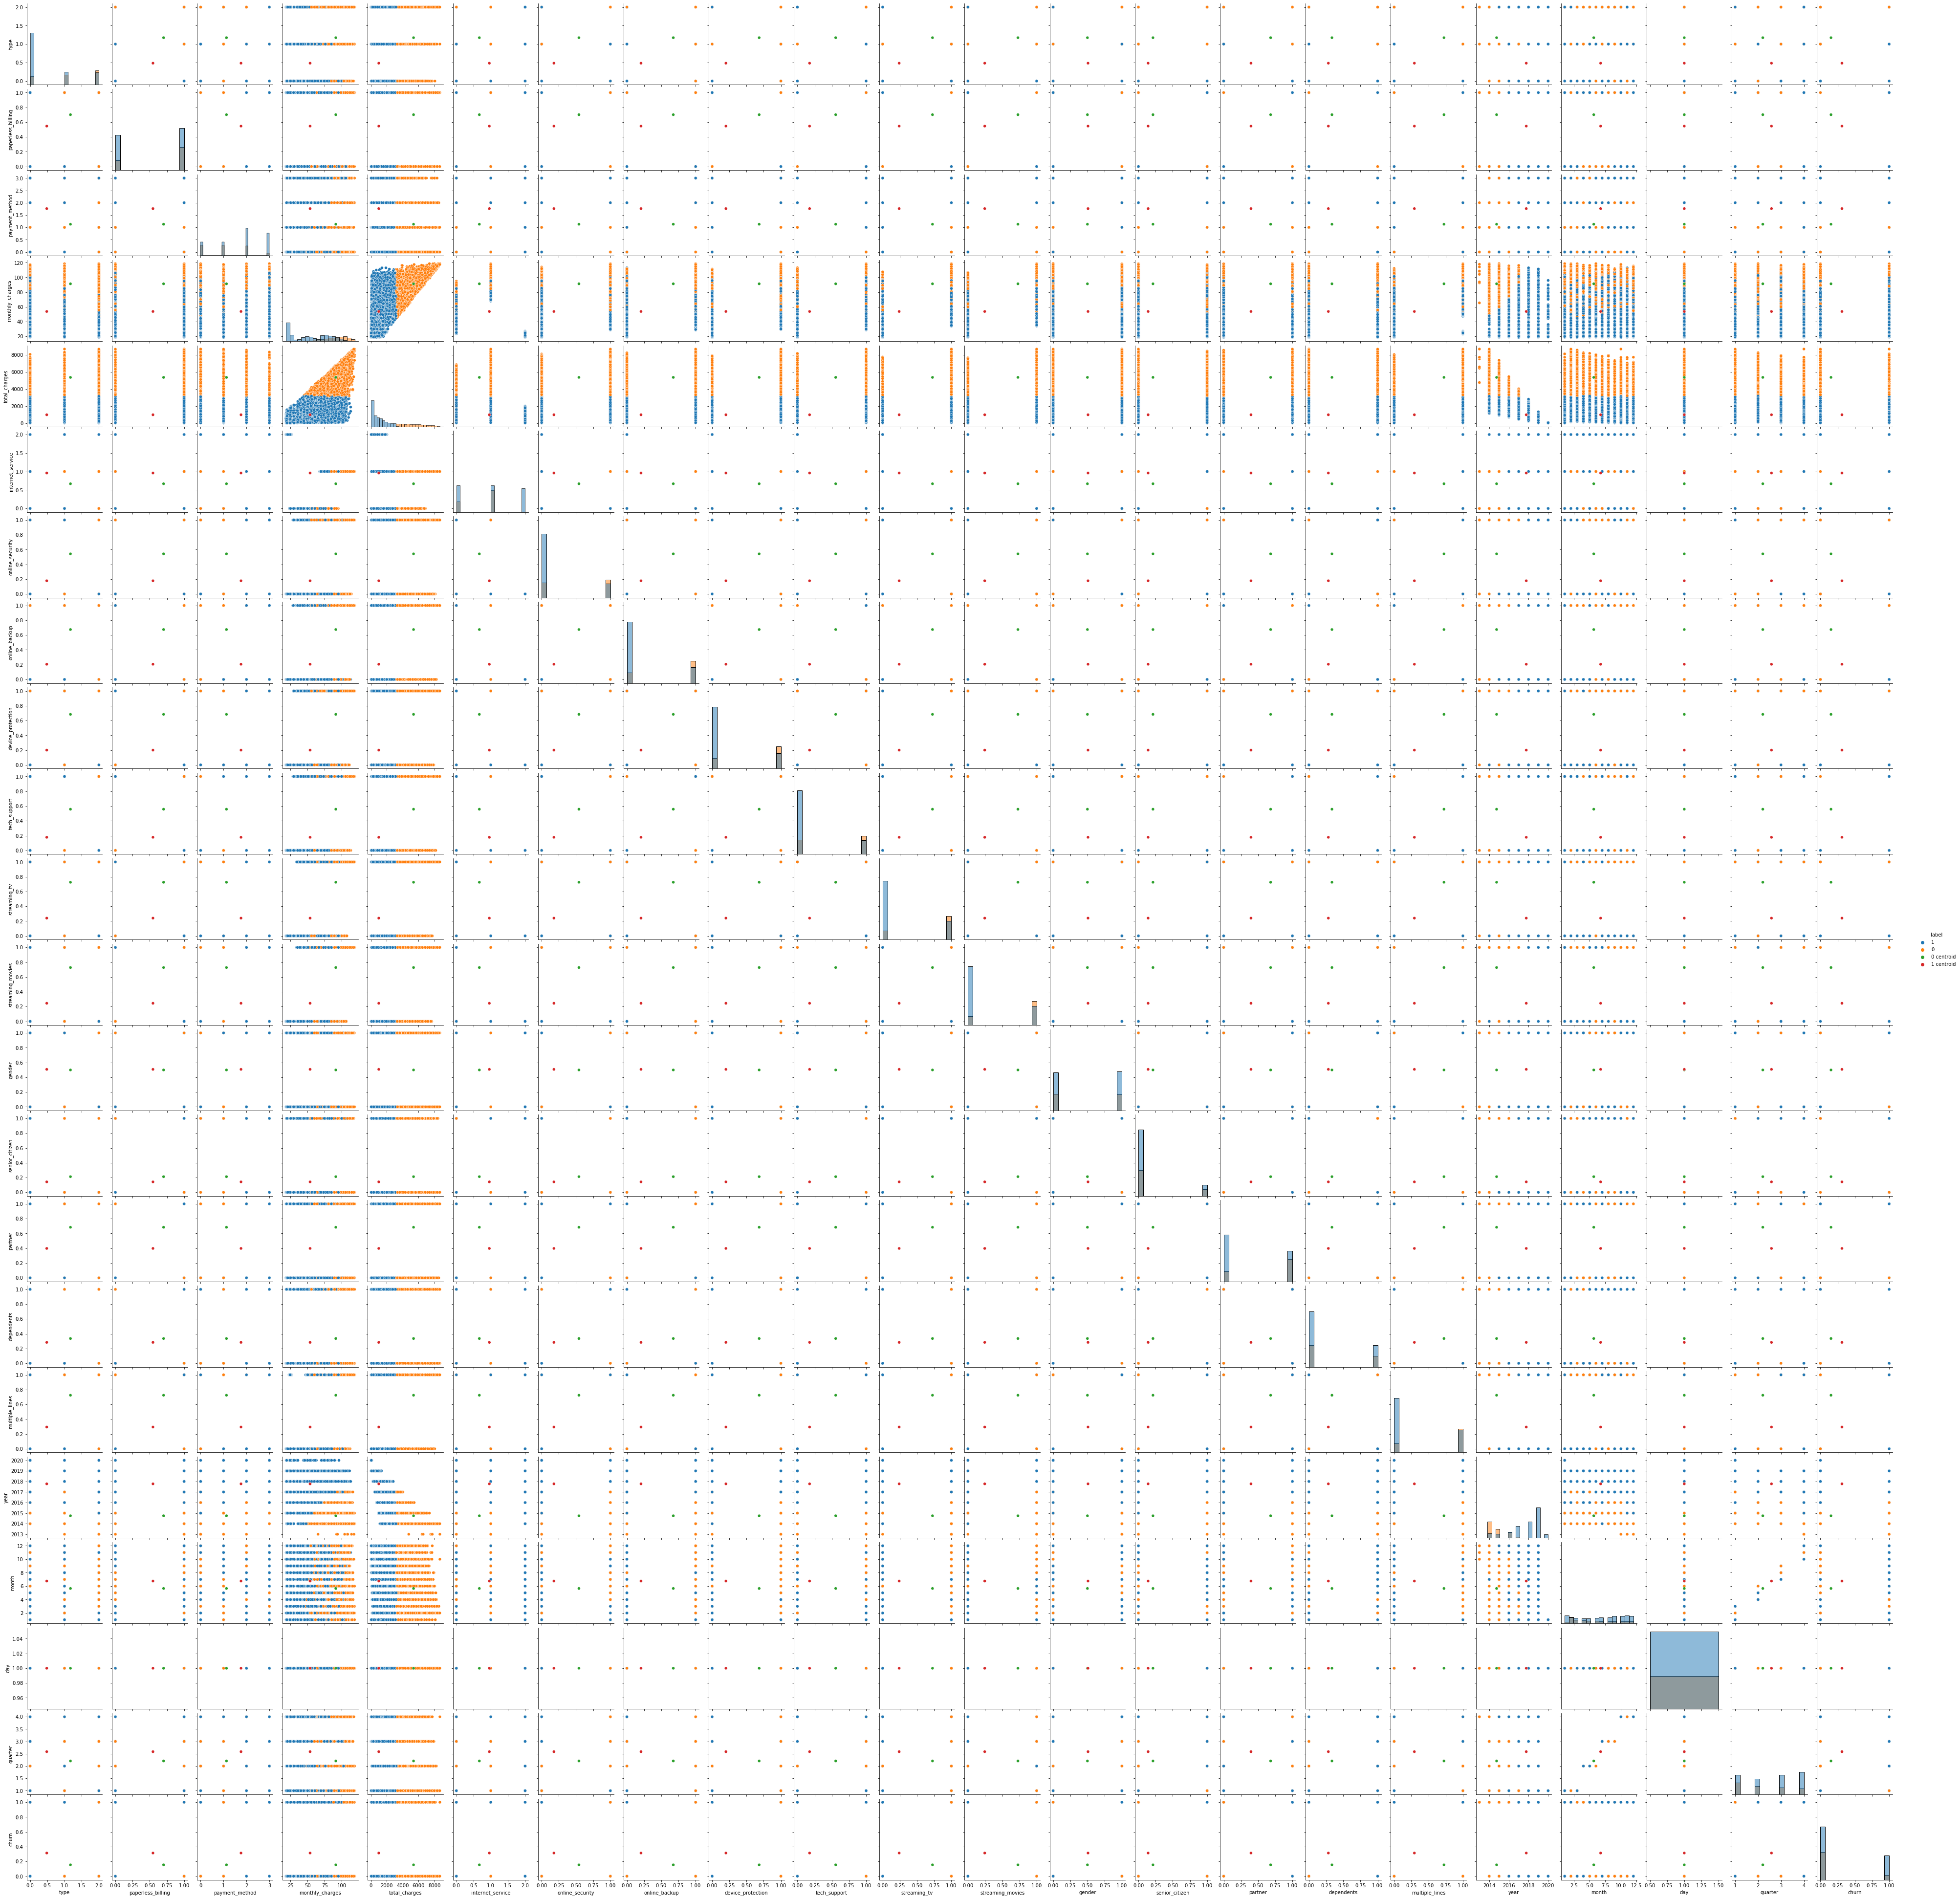

In [53]:
# pairplot 

centroids = pd.DataFrame(km.cluster_centers_, columns=df_copy.columns)
df_copy['label'] = km.labels_.astype(str)
centroids['label'] = ['0 centroid', '1 centroid']
data_all = pd.concat([df_copy, centroids], ignore_index=True)

# Plot the graph
sns.pairplot(data_all, hue='label', diag_kind='hist')

Looking at the pairplot, we can clearly see the two clusters in various category pairs. 

## <a id='toc5_2_'></a>[Modeling](#toc0_)

### <a id='toc5_2_1_'></a>[Classifier Pipeline](#toc0_)

In [54]:
# K fold cross val
kf = KFold(n_splits=5, shuffle=True, random_state=19)

We initially used K-fold cross validation for hyperparameter tuning using gridsearch cv.

In [55]:
# Classifier pipeline
pipe_ada = Pipeline([('scalar1', StandardScaler()), ('oversampler1', SMOTE(random_state=19)), ('ada_classifier', AdaBoostClassifier(n_estimators=500,  random_state=19, learning_rate=0.1))])

pipe_xg = Pipeline([('scalar1', StandardScaler()), ('oversampler1', SMOTE(random_state=19)), ('xg_classifier', XGBClassifier(learning_rate=0.5, max_depth=5, n_estimators=1500))])

pipe_lgbm = Pipeline([('scalar1', StandardScaler()), ('oversampler1', SMOTE(random_state=19)), ('lgbm_classifier', lgb.LGBMClassifier(num_boost_round=500, objective='binary', metric='auc', random_state=19, learning_rate=0.1, n_estimators=350, num_leaves=30, max_depth=20, boosting_type='gbdt'))])

pipe_gb = Pipeline([('scalar1', StandardScaler()), ('oversampler1', SMOTE(random_state=19)), ('gb_classifier', GradientBoostingClassifier(n_estimators=1500, learning_rate=0.1, random_state=19, max_depth=5))])

pipe_cat = Pipeline([('scalar1', StandardScaler()), ('oversampler1', SMOTE(random_state=19)), ('cat_classifier', CatBoostClassifier(task_type='GPU', loss_function='Logloss', eval_metric='AUC', iterations=1500, random_seed=19))])

pipe_vote = Pipeline([('scalar1', StandardScaler()), ('oversampler1', SMOTE(random_state=19)), ('vote_classifier', VotingClassifier(estimators=[('ada', pipe_ada), ('xgb', pipe_xg), ('lgb', pipe_lgbm), ('cat', pipe_cat)], verbose=1, voting='soft'))])

pipelines = [pipe_ada, pipe_xg, pipe_lgbm, pipe_gb, pipe_cat, pipe_vote]

best_auc = 0
best_classifier = 0
best_pipeline = ""

pipe_dict = {0: 'ADA Boost', 1: 'XG Boost', 2: 'Light GBM', 3: 'Gradient Boost', 4: 'Cat Boost', 5: 'Voting Classifier'}

# Use cross-validation to evaluate the models
for i, model in enumerate(pipelines):
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    print('{} Cross-Validation AUC-ROC: {:.2f}'.format(pipe_dict[i], scores.mean()))
    if scores.mean() > best_auc:
        best_auc = scores.mean()
        best_pipeline = model
        best_classifier = i

# Print the best classifier
print('\nClassifier with the best AUC-ROC: {}'.format(pipe_dict[best_classifier]))

ADA Boost Cross-Validation AUC-ROC: 0.87
XG Boost Cross-Validation AUC-ROC: 0.93
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500


c:\Users\XIX\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\XIX\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500


c:\Users\XIX\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500


c:\Users\XIX\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500


c:\Users\XIX\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
Light GBM Cross-Validation AUC-ROC: 0.92
Gradient Boost Cross-Validation AUC-ROC: 0.91
Learning rate set to 0.021203


Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 48.6ms	remaining: 1m 12s
1:	total: 95ms	remaining: 1m 11s
2:	total: 145ms	remaining: 1m 12s
3:	total: 192ms	remaining: 1m 11s
4:	total: 241ms	remaining: 1m 11s
5:	total: 289ms	remaining: 1m 12s
6:	total: 336ms	remaining: 1m 11s
7:	total: 383ms	remaining: 1m 11s
8:	total: 428ms	remaining: 1m 10s
9:	total: 472ms	remaining: 1m 10s
10:	total: 519ms	remaining: 1m 10s
11:	total: 566ms	remaining: 1m 10s
12:	total: 611ms	remaining: 1m 9s
13:	total: 657ms	remaining: 1m 9s
14:	total: 703ms	remaining: 1m 9s
15:	total: 750ms	remaining: 1m 9s
16:	total: 796ms	remaining: 1m 9s
17:	total: 842ms	remaining: 1m 9s
18:	total: 886ms	remaining: 1m 9s
19:	total: 931ms	remaining: 1m 8s
20:	total: 978ms	remaining: 1m 8s
21:	total: 1.02s	remaining: 1m 8s
22:	total: 1.07s	remaining: 1m 8s
23:	total: 1.12s	remaining: 1m 8s
24:	total: 1.16s	remaining: 1m 8s
25:	total: 1.21s	remaining: 1m 8s
26:	total: 1.26s	remaining: 1m 8s
27:	total: 1.3s	remaining: 1m 8s
28:	total: 1.34s	remaining: 1m 8s
29:	total: 1.

Default metric period is 5 because AUC is/are not implemented for GPU


4:	total: 241ms	remaining: 1m 12s
5:	total: 290ms	remaining: 1m 12s
6:	total: 337ms	remaining: 1m 11s
7:	total: 383ms	remaining: 1m 11s
8:	total: 427ms	remaining: 1m 10s
9:	total: 475ms	remaining: 1m 10s
10:	total: 519ms	remaining: 1m 10s
11:	total: 564ms	remaining: 1m 9s
12:	total: 611ms	remaining: 1m 9s
13:	total: 660ms	remaining: 1m 10s
14:	total: 709ms	remaining: 1m 10s
15:	total: 756ms	remaining: 1m 10s
16:	total: 801ms	remaining: 1m 9s
17:	total: 850ms	remaining: 1m 10s
18:	total: 894ms	remaining: 1m 9s
19:	total: 939ms	remaining: 1m 9s
20:	total: 985ms	remaining: 1m 9s
21:	total: 1.03s	remaining: 1m 9s
22:	total: 1.07s	remaining: 1m 9s
23:	total: 1.12s	remaining: 1m 8s
24:	total: 1.17s	remaining: 1m 8s
25:	total: 1.21s	remaining: 1m 8s
26:	total: 1.26s	remaining: 1m 8s
27:	total: 1.3s	remaining: 1m 8s
28:	total: 1.34s	remaining: 1m 8s
29:	total: 1.39s	remaining: 1m 8s
30:	total: 1.43s	remaining: 1m 7s
31:	total: 1.48s	remaining: 1m 8s
32:	total: 1.53s	remaining: 1m 7s
33:	total:

Default metric period is 5 because AUC is/are not implemented for GPU


3:	total: 202ms	remaining: 1m 15s
4:	total: 253ms	remaining: 1m 15s
5:	total: 301ms	remaining: 1m 14s
6:	total: 348ms	remaining: 1m 14s
7:	total: 396ms	remaining: 1m 13s
8:	total: 444ms	remaining: 1m 13s
9:	total: 492ms	remaining: 1m 13s
10:	total: 540ms	remaining: 1m 13s
11:	total: 591ms	remaining: 1m 13s
12:	total: 639ms	remaining: 1m 13s
13:	total: 687ms	remaining: 1m 12s
14:	total: 735ms	remaining: 1m 12s
15:	total: 785ms	remaining: 1m 12s
16:	total: 835ms	remaining: 1m 12s
17:	total: 883ms	remaining: 1m 12s
18:	total: 928ms	remaining: 1m 12s
19:	total: 978ms	remaining: 1m 12s
20:	total: 1.02s	remaining: 1m 12s
21:	total: 1.07s	remaining: 1m 11s
22:	total: 1.12s	remaining: 1m 11s
23:	total: 1.17s	remaining: 1m 11s
24:	total: 1.21s	remaining: 1m 11s
25:	total: 1.26s	remaining: 1m 11s
26:	total: 1.31s	remaining: 1m 11s
27:	total: 1.35s	remaining: 1m 11s
28:	total: 1.4s	remaining: 1m 11s
29:	total: 1.45s	remaining: 1m 10s
30:	total: 1.49s	remaining: 1m 10s
31:	total: 1.54s	remaining: 

Default metric period is 5 because AUC is/are not implemented for GPU


3:	total: 200ms	remaining: 1m 14s
4:	total: 247ms	remaining: 1m 13s
5:	total: 293ms	remaining: 1m 13s
6:	total: 339ms	remaining: 1m 12s
7:	total: 390ms	remaining: 1m 12s
8:	total: 437ms	remaining: 1m 12s
9:	total: 486ms	remaining: 1m 12s
10:	total: 531ms	remaining: 1m 11s
11:	total: 578ms	remaining: 1m 11s
12:	total: 624ms	remaining: 1m 11s
13:	total: 671ms	remaining: 1m 11s
14:	total: 719ms	remaining: 1m 11s
15:	total: 767ms	remaining: 1m 11s
16:	total: 812ms	remaining: 1m 10s
17:	total: 856ms	remaining: 1m 10s
18:	total: 901ms	remaining: 1m 10s
19:	total: 948ms	remaining: 1m 10s
20:	total: 995ms	remaining: 1m 10s
21:	total: 1.04s	remaining: 1m 9s
22:	total: 1.09s	remaining: 1m 9s
23:	total: 1.14s	remaining: 1m 9s
24:	total: 1.18s	remaining: 1m 9s
25:	total: 1.23s	remaining: 1m 9s
26:	total: 1.28s	remaining: 1m 9s
27:	total: 1.32s	remaining: 1m 9s
28:	total: 1.37s	remaining: 1m 9s
29:	total: 1.42s	remaining: 1m 9s
30:	total: 1.46s	remaining: 1m 9s
31:	total: 1.51s	remaining: 1m 9s
32:

Default metric period is 5 because AUC is/are not implemented for GPU


3:	total: 206ms	remaining: 1m 16s
4:	total: 254ms	remaining: 1m 16s
5:	total: 302ms	remaining: 1m 15s
6:	total: 349ms	remaining: 1m 14s
7:	total: 397ms	remaining: 1m 14s
8:	total: 444ms	remaining: 1m 13s
9:	total: 491ms	remaining: 1m 13s
10:	total: 536ms	remaining: 1m 12s
11:	total: 585ms	remaining: 1m 12s
12:	total: 630ms	remaining: 1m 12s
13:	total: 682ms	remaining: 1m 12s
14:	total: 736ms	remaining: 1m 12s
15:	total: 782ms	remaining: 1m 12s
16:	total: 830ms	remaining: 1m 12s
17:	total: 879ms	remaining: 1m 12s
18:	total: 922ms	remaining: 1m 11s
19:	total: 970ms	remaining: 1m 11s
20:	total: 1.01s	remaining: 1m 11s
21:	total: 1.06s	remaining: 1m 11s
22:	total: 1.11s	remaining: 1m 11s
23:	total: 1.16s	remaining: 1m 11s
24:	total: 1.21s	remaining: 1m 11s
25:	total: 1.27s	remaining: 1m 11s
26:	total: 1.31s	remaining: 1m 11s
27:	total: 1.37s	remaining: 1m 11s
28:	total: 1.42s	remaining: 1m 11s
29:	total: 1.47s	remaining: 1m 12s
30:	total: 1.52s	remaining: 1m 12s
31:	total: 1.58s	remaining:

c:\Users\XIX\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[Voting] ...................... (3 of 4) Processing lgb, total=   1.3s
Learning rate set to 0.021203
0:	total: 52.3ms	remaining: 1m 18s
1:	total: 109ms	remaining: 1m 21s
2:	total: 172ms	remaining: 1m 26s


Default metric period is 5 because AUC is/are not implemented for GPU


3:	total: 221ms	remaining: 1m 22s
4:	total: 272ms	remaining: 1m 21s
5:	total: 326ms	remaining: 1m 21s
6:	total: 378ms	remaining: 1m 20s
7:	total: 430ms	remaining: 1m 20s
8:	total: 481ms	remaining: 1m 19s
9:	total: 532ms	remaining: 1m 19s
10:	total: 585ms	remaining: 1m 19s
11:	total: 634ms	remaining: 1m 18s
12:	total: 685ms	remaining: 1m 18s
13:	total: 737ms	remaining: 1m 18s
14:	total: 789ms	remaining: 1m 18s
15:	total: 842ms	remaining: 1m 18s
16:	total: 891ms	remaining: 1m 17s
17:	total: 948ms	remaining: 1m 18s
18:	total: 996ms	remaining: 1m 17s
19:	total: 1.04s	remaining: 1m 17s
20:	total: 1.1s	remaining: 1m 17s
21:	total: 1.15s	remaining: 1m 17s
22:	total: 1.2s	remaining: 1m 17s
23:	total: 1.25s	remaining: 1m 17s
24:	total: 1.31s	remaining: 1m 17s
25:	total: 1.36s	remaining: 1m 17s
26:	total: 1.41s	remaining: 1m 16s
27:	total: 1.46s	remaining: 1m 16s
28:	total: 1.51s	remaining: 1m 16s
29:	total: 1.56s	remaining: 1m 16s
30:	total: 1.62s	remaining: 1m 16s
31:	total: 1.67s	remaining: 1

c:\Users\XIX\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[Voting] ...................... (3 of 4) Processing lgb, total=   1.1s
Learning rate set to 0.021203
0:	total: 55.4ms	remaining: 1m 23s
1:	total: 108ms	remaining: 1m 21s


Default metric period is 5 because AUC is/are not implemented for GPU


2:	total: 256ms	remaining: 2m 7s
3:	total: 306ms	remaining: 1m 54s
4:	total: 356ms	remaining: 1m 46s
5:	total: 405ms	remaining: 1m 40s
6:	total: 453ms	remaining: 1m 36s
7:	total: 502ms	remaining: 1m 33s
8:	total: 548ms	remaining: 1m 30s
9:	total: 596ms	remaining: 1m 28s
10:	total: 643ms	remaining: 1m 27s
11:	total: 689ms	remaining: 1m 25s
12:	total: 737ms	remaining: 1m 24s
13:	total: 783ms	remaining: 1m 23s
14:	total: 831ms	remaining: 1m 22s
15:	total: 879ms	remaining: 1m 21s
16:	total: 926ms	remaining: 1m 20s
17:	total: 974ms	remaining: 1m 20s
18:	total: 1.02s	remaining: 1m 19s
19:	total: 1.07s	remaining: 1m 19s
20:	total: 1.12s	remaining: 1m 18s
21:	total: 1.17s	remaining: 1m 18s
22:	total: 1.22s	remaining: 1m 18s
23:	total: 1.27s	remaining: 1m 18s
24:	total: 1.32s	remaining: 1m 17s
25:	total: 1.36s	remaining: 1m 17s
26:	total: 1.41s	remaining: 1m 16s
27:	total: 1.45s	remaining: 1m 16s
28:	total: 1.5s	remaining: 1m 16s
29:	total: 1.54s	remaining: 1m 15s
30:	total: 1.59s	remaining: 1m

c:\Users\XIX\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[Voting] ...................... (3 of 4) Processing lgb, total=   1.0s
Learning rate set to 0.021203
0:	total: 50.6ms	remaining: 1m 15s
1:	total: 102ms	remaining: 1m 16s
2:	total: 154ms	remaining: 1m 16s


Default metric period is 5 because AUC is/are not implemented for GPU


3:	total: 203ms	remaining: 1m 16s
4:	total: 251ms	remaining: 1m 14s
5:	total: 298ms	remaining: 1m 14s
6:	total: 346ms	remaining: 1m 13s
7:	total: 394ms	remaining: 1m 13s
8:	total: 443ms	remaining: 1m 13s
9:	total: 492ms	remaining: 1m 13s
10:	total: 538ms	remaining: 1m 12s
11:	total: 589ms	remaining: 1m 13s
12:	total: 638ms	remaining: 1m 12s
13:	total: 690ms	remaining: 1m 13s
14:	total: 740ms	remaining: 1m 13s
15:	total: 794ms	remaining: 1m 13s
16:	total: 845ms	remaining: 1m 13s
17:	total: 899ms	remaining: 1m 14s
18:	total: 946ms	remaining: 1m 13s
19:	total: 996ms	remaining: 1m 13s
20:	total: 1.04s	remaining: 1m 13s
21:	total: 1.09s	remaining: 1m 13s
22:	total: 1.14s	remaining: 1m 13s
23:	total: 1.19s	remaining: 1m 13s
24:	total: 1.24s	remaining: 1m 13s
25:	total: 1.29s	remaining: 1m 13s
26:	total: 1.34s	remaining: 1m 13s
27:	total: 1.39s	remaining: 1m 13s
28:	total: 1.43s	remaining: 1m 12s
29:	total: 1.48s	remaining: 1m 12s
30:	total: 1.54s	remaining: 1m 12s
31:	total: 1.59s	remaining:

c:\Users\XIX\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[Voting] ...................... (3 of 4) Processing lgb, total=   1.1s
Learning rate set to 0.021203
0:	total: 64.5ms	remaining: 1m 36s


Default metric period is 5 because AUC is/are not implemented for GPU


1:	total: 261ms	remaining: 3m 15s
2:	total: 315ms	remaining: 2m 37s
3:	total: 367ms	remaining: 2m 17s
4:	total: 428ms	remaining: 2m 8s
5:	total: 486ms	remaining: 2m
6:	total: 533ms	remaining: 1m 53s
7:	total: 592ms	remaining: 1m 50s
8:	total: 653ms	remaining: 1m 48s
9:	total: 716ms	remaining: 1m 46s
10:	total: 766ms	remaining: 1m 43s
11:	total: 821ms	remaining: 1m 41s
12:	total: 877ms	remaining: 1m 40s
13:	total: 927ms	remaining: 1m 38s
14:	total: 985ms	remaining: 1m 37s
15:	total: 1.04s	remaining: 1m 36s
16:	total: 1.09s	remaining: 1m 35s
17:	total: 1.15s	remaining: 1m 34s
18:	total: 1.2s	remaining: 1m 33s
19:	total: 1.26s	remaining: 1m 33s
20:	total: 1.32s	remaining: 1m 33s
21:	total: 1.38s	remaining: 1m 32s
22:	total: 1.43s	remaining: 1m 31s
23:	total: 1.49s	remaining: 1m 31s
24:	total: 1.55s	remaining: 1m 31s
25:	total: 1.6s	remaining: 1m 30s
26:	total: 1.66s	remaining: 1m 30s
27:	total: 1.72s	remaining: 1m 30s
28:	total: 1.76s	remaining: 1m 29s
29:	total: 1.82s	remaining: 1m 29s
3

c:\Users\XIX\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[Voting] ...................... (3 of 4) Processing lgb, total=   1.0s
Learning rate set to 0.021203
0:	total: 59.7ms	remaining: 1m 29s
1:	total: 122ms	remaining: 1m 31s
2:	total: 180ms	remaining: 1m 29s


Default metric period is 5 because AUC is/are not implemented for GPU


3:	total: 233ms	remaining: 1m 27s
4:	total: 291ms	remaining: 1m 27s
5:	total: 345ms	remaining: 1m 25s
6:	total: 392ms	remaining: 1m 23s
7:	total: 452ms	remaining: 1m 24s
8:	total: 499ms	remaining: 1m 22s
9:	total: 552ms	remaining: 1m 22s
10:	total: 607ms	remaining: 1m 22s
11:	total: 655ms	remaining: 1m 21s
12:	total: 708ms	remaining: 1m 20s
13:	total: 763ms	remaining: 1m 20s
14:	total: 816ms	remaining: 1m 20s
15:	total: 868ms	remaining: 1m 20s
16:	total: 922ms	remaining: 1m 20s
17:	total: 973ms	remaining: 1m 20s
18:	total: 1.03s	remaining: 1m 20s
19:	total: 1.07s	remaining: 1m 19s
20:	total: 1.13s	remaining: 1m 19s
21:	total: 1.19s	remaining: 1m 19s
22:	total: 1.24s	remaining: 1m 19s
23:	total: 1.29s	remaining: 1m 19s
24:	total: 1.35s	remaining: 1m 19s
25:	total: 1.4s	remaining: 1m 19s
26:	total: 1.46s	remaining: 1m 19s
27:	total: 1.52s	remaining: 1m 19s
28:	total: 1.56s	remaining: 1m 19s
29:	total: 1.62s	remaining: 1m 19s
30:	total: 1.68s	remaining: 1m 19s
31:	total: 1.72s	remaining: 

We used a pipeline to determine the best classifier to use. We used a standard scaler and SMOTE for preprocessing. The models with the best cross validation scores on the training set was the voting classifier and XG Boost. Therefore, we will implement the voting classifier and measure the model against the test data set. 

#### <a id='toc5_2_1_1_'></a>[ADA Pipeline Feature Importance](#toc0_)

In [56]:
# Ada pipeline feature importance
pipe_ada.fit(X_train, y_train)

ada_classifier = pipe_ada.named_steps['ada_classifier']
ada_importances = ada_classifier.feature_importances_
ada_indices = np.argsort(ada_importances)[::-1]

top_10_features = []
for f in range(10):
    feature_index = ada_indices[f]
    feature_name = X_train.columns[feature_index]
    top_10_features.append((feature_name, ada_importances[feature_index]))

ada_top_10_df = pd.DataFrame(top_10_features, columns=['Feature', 'Importance'])


In [57]:
# ADA feature imprtance
px.pie(ada_top_10_df, names='Feature', values='Importance', title='ADA Boost Feature Importance', template='ggplot2')

#### <a id='toc5_2_1_2_'></a>[XGBoost Pipeline Feature Importance](#toc0_)

In [58]:
# XG Boost pipeline feature importance
pipe_xg.fit(X_train, y_train)

xg_classifier = pipe_xg.named_steps['xg_classifier']
xg_importances = xg_classifier.feature_importances_
xg_indices = np.argsort(xg_importances)[::-1]

top_10_features = []
for f in range(10):
    feature_index = xg_indices[f]
    feature_name = X_train.columns[feature_index]
    top_10_features.append((feature_name, xg_importances[feature_index]))

xg_top_10_df = pd.DataFrame(top_10_features, columns=['Feature', 'Importance'])


In [59]:
# XGB feature importance
px.pie(xg_top_10_df, names='Feature', values='Importance', title='XG Boost Feature Importance', template='ggplot2')

#### <a id='toc5_2_1_3_'></a>[LGBM Pipeline Feature Importance](#toc0_)

In [60]:
# Light GBM pipeline feature importance
pipe_lgbm.fit(X_train, y_train)

lg_classifier = pipe_lgbm.named_steps['lgbm_classifier']
lg_importances = lg_classifier.feature_importances_
lg_indices = np.argsort(lg_importances)[::-1]

top_10_features = []
for f in range(10):
    feature_index = lg_indices[f]
    feature_name = X_train.columns[feature_index]
    top_10_features.append((feature_name, lg_importances[feature_index]))

lg_top_10_df = pd.DataFrame(top_10_features, columns=['Feature', 'Importance'])


c:\Users\XIX\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500


In [61]:
# LGBM feature importance
px.pie(lg_top_10_df, names='Feature', values='Importance', title='Light GBM Feature Importance', template='ggplot2')

#### <a id='toc5_2_1_4_'></a>[Gradient Boost Pipeline Feature Importance](#toc0_)

In [62]:
# Gradient Boost pipeline feature importance
pipe_gb.fit(X_train, y_train)

gb_classifier = pipe_gb.named_steps['gb_classifier']
gb_importances = gb_classifier.feature_importances_
gb_indices = np.argsort(gb_importances)[::-1]

top_10_features = []
for f in range(10):
    feature_index = gb_indices[f]
    feature_name = X_train.columns[feature_index]
    top_10_features.append((feature_name, gb_importances[feature_index]))

gb_top_10_df = pd.DataFrame(top_10_features, columns=['Feature', 'Importance'])


In [63]:
# gb feature importance
px.pie(gb_top_10_df, names='Feature', values='Importance', title='Gradient Boost Feature Importance', template='ggplot2')

#### <a id='toc5_2_1_5_'></a>[CatBoost Pipeline Feature Importance](#toc0_)

In [64]:
# Cat Boost pipeline feature importance
pipe_cat.fit(X_train, y_train)

cat_classifier = pipe_cat.named_steps['cat_classifier']
cat_importances = cat_classifier.feature_importances_
cat_indices = np.argsort(cat_importances)[::-1]

top_10_features = []
for f in range(10):
    feature_index = cat_indices[f]
    feature_name = X_train.columns[feature_index]
    top_10_features.append((feature_name, cat_importances[feature_index]))

cat_top_10_df = pd.DataFrame(top_10_features, columns=['Feature', 'Importance'])


Learning rate set to 0.020944
0:	total: 53.3ms	remaining: 1m 19s
1:	total: 121ms	remaining: 1m 30s


Default metric period is 5 because AUC is/are not implemented for GPU


2:	total: 187ms	remaining: 1m 33s
3:	total: 251ms	remaining: 1m 33s
4:	total: 306ms	remaining: 1m 31s
5:	total: 370ms	remaining: 1m 32s
6:	total: 431ms	remaining: 1m 31s
7:	total: 495ms	remaining: 1m 32s
8:	total: 553ms	remaining: 1m 31s
9:	total: 616ms	remaining: 1m 31s
10:	total: 680ms	remaining: 1m 32s
11:	total: 741ms	remaining: 1m 31s
12:	total: 795ms	remaining: 1m 30s
13:	total: 856ms	remaining: 1m 30s
14:	total: 919ms	remaining: 1m 30s
15:	total: 980ms	remaining: 1m 30s
16:	total: 1.03s	remaining: 1m 30s
17:	total: 1.09s	remaining: 1m 30s
18:	total: 1.16s	remaining: 1m 30s
19:	total: 1.24s	remaining: 1m 31s
20:	total: 1.33s	remaining: 1m 33s
21:	total: 1.41s	remaining: 1m 34s
22:	total: 1.46s	remaining: 1m 34s
23:	total: 1.52s	remaining: 1m 33s
24:	total: 1.59s	remaining: 1m 33s
25:	total: 1.65s	remaining: 1m 33s
26:	total: 1.7s	remaining: 1m 32s
27:	total: 1.76s	remaining: 1m 32s
28:	total: 1.82s	remaining: 1m 32s
29:	total: 1.92s	remaining: 1m 33s
30:	total: 2s	remaining: 1m 3

In [65]:
# cat boost feature importance
px.pie(cat_top_10_df, names='Feature', values='Importance', title='Cat Boost Feature Importance', template='ggplot2')

### <a id='toc5_2_2_'></a>[Comparing Models](#toc0_)

In [73]:
# series of model scores
data = {'Ada Boost': 0.87, 'XG Boost': 0.93 , 'LGBM': 0.92, 'Gradient Boost': 0.91, 'Cat Boost': 0.92, 'Voting Classifier': 0.93 }
comp = pd.Series(data, name='Auc-Roc Score')
comp

Ada Boost            0.87
XG Boost             0.93
LGBM                 0.92
Gradient Boost       0.91
Cat Boost            0.92
Voting Classifier    0.93
Name: Auc-Roc Score, dtype: float64

In [83]:
# model scores
px.scatter(comp, color=comp.index, size=comp, title='Model Comparison', symbol=comp, labels={'index': 'Model', 'value': 'AUC-ROC Score'})

## <a id='toc5_3_'></a>[Final Model](#toc0_)

In [68]:
# Final model

class1 = AdaBoostClassifier(n_estimators=400, random_state=19, learning_rate=0.1)
class2 = GradientBoostingClassifier(n_estimators=1500, learning_rate=0.1, random_state=19, max_depth=5)
class3 = XGBClassifier(learning_rate=0.5, max_depth=5, n_estimators=1500) 
class4 = lgb.LGBMClassifier(objective='binary', metric='auc', boosting_type='gbdt', learning_rate=0.1, max_depth=20, n_estimators=350, num_leaves=30, random_state=19) 
class5 = CatBoostClassifier(task_type='GPU', loss_function='Logloss', eval_metric='AUC', iterations=1500, random_seed=19)
 

final = VotingClassifier(estimators=[('ada', class1), 
                                #('gbr', class2), 
                                ('xgb', class3), 
                                ('lgb', class4), 
                                ('cat', class5)], 
                                verbose=1, voting='soft')
final = final.fit(X_train, y_train)

# Make predictions on the test set
final_predictions = final.predict(X_test)

result = roc_auc_score(y_test, final_predictions)
print()
print("Voting Classifier model on the test set: ", result)

[Voting] ...................... (1 of 4) Processing ada, total=   2.2s
[Voting] ...................... (2 of 4) Processing xgb, total=   5.6s
[Voting] ...................... (3 of 4) Processing lgb, total=   0.6s
Learning rate set to 0.021393


Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 63.8ms	remaining: 1m 35s
1:	total: 120ms	remaining: 1m 30s
2:	total: 178ms	remaining: 1m 28s
3:	total: 229ms	remaining: 1m 25s
4:	total: 285ms	remaining: 1m 25s
5:	total: 346ms	remaining: 1m 26s
6:	total: 396ms	remaining: 1m 24s
7:	total: 455ms	remaining: 1m 24s
8:	total: 511ms	remaining: 1m 24s
9:	total: 561ms	remaining: 1m 23s
10:	total: 620ms	remaining: 1m 23s
11:	total: 668ms	remaining: 1m 22s
12:	total: 723ms	remaining: 1m 22s
13:	total: 781ms	remaining: 1m 22s
14:	total: 826ms	remaining: 1m 21s
15:	total: 884ms	remaining: 1m 21s
16:	total: 939ms	remaining: 1m 21s
17:	total: 986ms	remaining: 1m 21s
18:	total: 1.04s	remaining: 1m 21s
19:	total: 1.1s	remaining: 1m 21s
20:	total: 1.14s	remaining: 1m 20s
21:	total: 1.19s	remaining: 1m 20s
22:	total: 1.24s	remaining: 1m 19s
23:	total: 1.29s	remaining: 1m 19s
24:	total: 1.35s	remaining: 1m 19s
25:	total: 1.4s	remaining: 1m 19s
26:	total: 1.46s	remaining: 1m 19s
27:	total: 1.51s	remaining: 1m 19s
28:	total: 1.56s	remaining: 1m 

### <a id='toc5_3_1_'></a>[Final Model Evaluation Metric](#toc0_)

In [69]:
# Display AUC ROC
probabilities_valid = final.predict_proba(X_test)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(y_test, probabilities_one_valid)

print(auc_roc)

# ROC AUC curve of results
fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_valid)

fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=800, height=600
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

0.9408955174768223


### <a id='toc5_3_2_'></a>[Final Model Feature Importances](#toc0_)

In [70]:
# function for extracting feature importance of each model in voting classifier
def compute_feature_importance(voting_clf, weights):
    """ Function to compute feature importance of Voting Classifier """
    
    feature_importance = dict()
    for est in voting_clf.estimators_:
        feature_importance[str(est)] = est.feature_importances_
    
    fe_scores = [0]*len(list(feature_importance.values())[0])
    for idx, imp_score in enumerate(feature_importance.values()):
        imp_score_with_weight = imp_score*weights[idx]
        fe_scores = list(np.add(fe_scores, list(imp_score_with_weight)))
    return fe_scores

In [71]:
# creating feature importance dataframe
fedf = pd.DataFrame()
fedf['Feature'] = X_train.columns
fedf['Feature Importance'] = compute_feature_importance(final, [1, 1, 1, 1])
fedf = fedf.sort_values('Feature Importance', ascending=False).head(10)

In [72]:
# voting classifier feature importance
px.pie(fedf, names='Feature', values='Feature Importance', title='Top 10 Features', template='ggplot2')

## <a id='toc5_4_'></a>[Overall Conclusions](#toc0_)

We succeeded in achieving our target AUC ROC score of 0.75. Our final score with the test set is 0.9409, which is roughly 25% more than our target. The boosting models generally had good scores with the training set, but to ensure a better score with the test set, we used a voting classifier. We also looked into the feature importance of the various models in our pipeline, and finally, the important features in our final model. We see that total charges and monthly charges are the most important features, followed by the time frame of the account opening with the year and month. It is reasonable to conclude features such as charges and the length of time a customer has had service, outweigh other factors such as demographics.

Therefore, Interconnect can utilize this model to predict churn. Alongside marketing strategies, the company can target customers likely to leave, and therefore implement strategies to prevent churn. They may also be interested in looking at trends in the charges of customers alongside the length of service, to periodically implement marketing strategies to prevent churn. 

## Solution Report

All steps of the final work plan were performed, yet we could have done without the K Means analysis, as the results of that model were difficult to interpret. 

Since we used a voting classifier as our final model, we found it difficult to illustrate the inner workings of this black box model. Therefore, we did extensive research to write a code that could extract the feature importance of each model in the ensemble, and give the average feature importance as the overall summary of the model. 

Key steps to a successful model and prediction were parsing the start dates into months and years. Furthermore, scaling the dataset and using SMOTE in the pipeline likely helped to achieve a good AUC-ROC score. The final model is a voting classifier with an AUC-ROC score of 0.9409. Choosing the voting classifier was a good decision, yet and XG Boost classifier may have been equally as good. 